# Identifying Entities in Healthcare Data

##Workspace set up: Import and Install useful packages.

In [1]:
import spacy
import sklearn_crfsuite
from sklearn_crfsuite import metrics
import pandas as pd

model = spacy.load("en_core_web_sm")

##Data Preprocessing

The dataset provided is in the form of one word per line. Let's understand the format of data below:
- Suppose there are *x* words in a sentence, then there will be *x* continuous lines with one word in each line. 
- Further, the two sentences are separated by empty lines. The labels for the data follow the same format.

**We need to pre-process the data to recover the complete sentences and their labels.**


### Construct the proper sentences from individual words and print the 5 sentences.

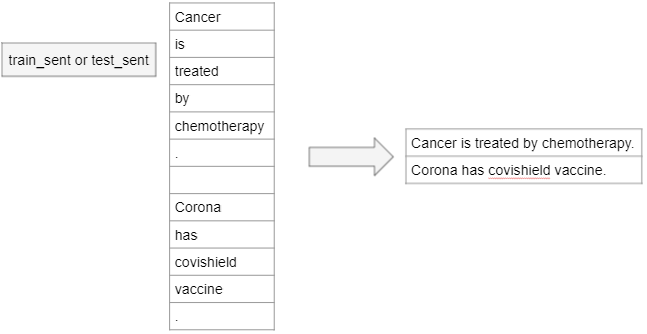

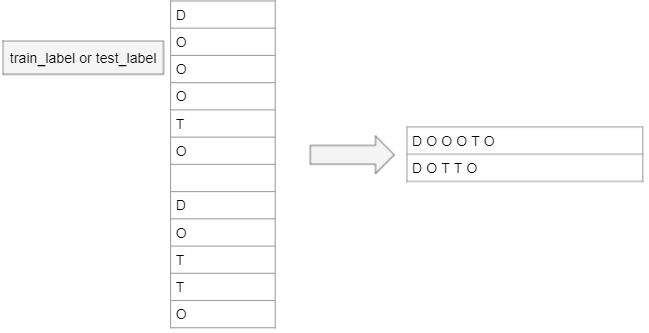

In [2]:
def read_data(f_name):
    with open(f_name) as file:
        tokens = file.readlines()

    sentence_list = []
    word_list = []

    for token in tokens:
        if token not in [' ', '\n', '']:
            token = token.replace('\n', '')
            word_list.append(token)
        else:
            sentence_list.append(' '.join(word_list))
            word_list = []
    sentence_list.append(' '.join(word_list))
    return sentence_list

In [4]:
file_train_sent = 'train_sent'
file_test_sent = 'test_sent'
file_train_label = 'train_label'
file_test_label = 'test_label'

# Read four given train and test set files and convert them into sentences
train_sent = read_data(file_train_sent)
test_sent = read_data(file_test_sent)
train_label = read_data(file_train_label)
test_label = read_data(file_test_label)


In [5]:
train_sent[:5]

['All live births > or = 23 weeks at the University of Vermont in 1995 ( n = 2395 ) were retrospectively analyzed for delivery route , indication for cesarean , gestational age , parity , and practice group ( to reflect risk status )',
 'The total cesarean rate was 14.4 % ( 344 of 2395 ) , and the primary rate was 11.4 % ( 244 of 2144 )',
 'Abnormal presentation was the most common indication ( 25.6 % , 88 of 344 )',
 "The `` corrected '' cesarean rate ( maternal-fetal medicine and transported patients excluded ) was 12.4 % ( 273 of 2194 ) , and the `` corrected '' primary rate was 9.6 % ( 190 of 1975 )",
 "Arrest of dilation was the most common indication in both `` corrected '' subgroups ( 23.4 and 24.6 % , respectively )"]

In [6]:
# View train sentences with labels
train_df = pd.DataFrame(columns=['Sentences', 'Labels'])
for i in range(len(train_sent)):
    train_df.loc[len(train_df)] = [train_sent[i], train_label[i]]
train_df.head(5)

,Sentences,Labels
0,All live births > or = 23 weeks at the Univers...,O O O O O O O O O O O O O O O O O O O O O O O ...
1,The total cesarean rate was 14.4 % ( 344 of 23...,O O O O O O O O O O O O O O O O O O O O O O O O O
2,Abnormal presentation was the most common indi...,O O O O O O O O O O O O O O O
3,The `` corrected '' cesarean rate ( maternal-f...,O O O O O O O O O O O O O O O O O O O O O O O ...
4,Arrest of dilation was the most common indicat...,O O O O O O O O O O O O O O O O O O O O O O


In [7]:
# View test sentences with labels
test_df = pd.DataFrame(columns=['Sentences', 'Labels'])
for i in range(len(test_sent)):
    test_df.loc[len(test_df)] = [test_sent[i], test_label[i]]
test_df.head(5)

,Sentences,Labels
0,"Furthermore , when all deliveries were analyze...",O O O O O O O O O O O O O O O O O O O O O O O ...
1,"As the ambient temperature increases , there i...",O O O O O O O O O O O O O O O O O O O
2,The daily high temperature ranged from 71 to 1...,O O O O O O O O O O O O O O O O O O O O O O O O
3,There was a significant correlation between th...,O O O O O O O O O O O O O O O O O O O O O O O ...
4,Fluctuations in ambient temperature are invers...,O O O O O O O O O O O


### Count the number of sentences in the processed train and test dataset 

In [9]:
print("Sentences count in train dataset :: ", len(train_sent))
print("Sentences count in test dataset :: ", len(test_sent))


Sentences count in train dataset ::  2600
Sentences count in test dataset ::  1057


### Count the number of lines of labels in the processed train and test dataset.

In [10]:
print("Labels count in train dataset :: ", len(train_label))
print("Labels count in test dataset :: ", len(test_label))

Labels count in train dataset ::  2600
Labels count in test dataset ::  1057


##Concept Identification

We will first explore what are the various concepts present in the dataset. For this, we will use PoS Tagging. 



### Extract those tokens which have NOUN or PROPN as their PoS tag and find their frequency

In [11]:
# Extracting words with POS tag as NOUN or PROPN from both train and test dataset

nouns = []

for sent in train_sent:
    doc = model(sent)
    for token in doc:
        if token.pos_ == "NOUN" or token.pos_ == "PROPN":
            nouns.append(token.lemma_.lower())

for sent in test_sent:
    doc = model(sent)
    for token in doc:
        if token.pos_ == "NOUN" or token.pos_ == "PROPN":
            nouns.append(token.lemma_.lower())
nouns


['birth',
 'week',
 'university',
 'vermont',
 'delivery',
 'route',
 'indication',
 'age',
 'parity',
 'practice',
 'group',
 'risk',
 'status',
 'rate',
 '%',
 'rate',
 '%',
 'presentation',
 'indication',
 '%',
 'rate',
 'medicine',
 'patient',
 '%',
 'rate',
 '%',
 'arrest',
 'dilation',
 'indication',
 'subgroup',
 '%',
 'rate',
 'care',
 'hospital',
 'rate',
 'community',
 'hospital',
 'group',
 'age',
 'trimester',
 'fluid',
 'index',
 'afi',
 'fluid',
 'status',
 'temperature',
 'increase',
 'decrease',
 'afi',
 'june',
 'august',
 'period',
 'heat',
 'woman',
 'singleton',
 'pregnancy',
 'week',
 'gestation',
 'testing',
 'afi',
 'determination',
 'ambient',
 'temperature',
 'area',
 'day',
 'mean',
 'temperature',
 'test',
 'date',
 'afi',
 'spearman',
 'rank',
 'correlation',
 'relationship',
 'account',
 'afi',
 'measure',
 'well',
 'being',
 'study',
 'population',
 'woman',
 'diabete',
 'screening',
 'woman',
 'clinic',
 'hadassah',
 'medical',
 'center',
 'year',
 'perio

### Print the top 25 most common tokens with NOUN or PROPN PoS tags

In [12]:
# Converting nouns list to pandas series to get frequencies of each element
noun_series = pd.Series(nouns).value_counts()

# Create a dictionary of noun:count
freq_dictionary = {}

for noun in nouns:
    freq_dictionary[noun] = noun_series.loc[noun]

# Using head() to print top 25 tokens
print(f"-------- Top 25 Most Common Tokens with NOUN or PROPN Tags --------")
noun_series.head(25)

-------- Top 25 Most Common Tokens with NOUN or PROPN Tags --------


patient         568
treatment       316
%               247
study           236
cancer          226
cell            203
therapy         182
effect          181
disease         170
group           145
case            132
result          121
lung            120
gene            111
year            105
rate            103
use              91
chemotherapy     91
trial            90
woman            89
conclusion       89
analysis         86
protein          82
response         81
risk             78
Name: count, dtype: int64

## Defining features for CRF





In [13]:
# Let's define the features to get the feature value for one word.

def getFeaturesForOneWord(words_list, token_pos_list, pos):
    '''
    Parameters:
    'words_list': words list in a sentence
    'token_pos_list': list of PoS tags of corresponding words
    'pos': word position in the words_list
    
    Returns:
    'features': a list of all the features of the word
    '''
    word = words_list[pos]

    features = [
        'word.PoS=' + token_pos_list[pos], # PoS tag of the word
        'word.lower=' + word.lower(),    # serves as word id
        'word[-3:]=' + word[-3:],        # last three characters
        'word[-2:]=' + word[-2:],        # last two characters
        'word.isupper=%s' % word.isupper(),  # is the word in all uppercase
        'word.isdigit=%s' % word.isdigit(),  # is the word a number
        'words.startsWithCapital=%s' % word[0].isupper() # is the word starting with a capital letter
      ]
        
    if(pos > 0):
            prev_word = words_list[pos-1]
            features.extend([
                'prev_word.PoS=' + token_pos_list[pos-1], # PoS tag of the previous word
                'prev_word.lower=' + prev_word.lower(), # previous word in lower case
                'prev_word[-3:]=' + prev_word[-3:],        # last three characters of previous word
                'prev_word[-2:]=' + prev_word[-2:],        # last two characters of previous word
                'prev_word.isupper=%s' % prev_word.isupper(), # is the previous word in all uppercase
                'prev_word.isdigit=%s' % prev_word.isdigit(), # is the previous word a number
                'prev_words.startsWithCapital=%s' % prev_word[0].isupper() # is the previous word starting with a capital letter
      ])
        
    else:
            features.append('BEG') # feature to track begin of sentence 
        
        
    if(i == len(words_list)-1):
            features.append('END') # feature to track end of sentence
        
    return features


## Getting the features

### Write a code/function to get the features for a sentence

In [14]:
# Write a code to get features for a sentence.
def getFeaturesForOneSentence(sentence):
    doc = model(sentence)
    token_pos_list = [token.pos_ for token in doc]
    words_list = sentence.split()
    return [getFeaturesForOneWord(words_list, token_pos_list, pos) for pos in range(len(words_list))]




### Write a code/function to get the labels of a sentence

In [15]:
# Write a code to get the labels for a sentence.
def getLabelsForOneSentence(labels):
    return labels.split()


In [16]:
sample_sentence = train_sent[0]
print(sample_sentence)

features = getFeaturesForOneSentence(sample_sentence)
features[1]



All live births > or = 23 weeks at the University of Vermont in 1995 ( n = 2395 ) were retrospectively analyzed for delivery route , indication for cesarean , gestational age , parity , and practice group ( to reflect risk status )


['word.PoS=ADJ',
 'word.lower=live',
 'word[-3:]=ive',
 'word[-2:]=ve',
 'word.isupper=False',
 'word.isdigit=False',
 'words.startsWithCapital=False',
 'prev_word.PoS=DET',
 'prev_word.lower=all',
 'prev_word[-3:]=All',
 'prev_word[-2:]=ll',
 'prev_word.isupper=False',
 'prev_word.isdigit=False',
 'prev_words.startsWithCapital=True']

In [17]:
labels = getLabelsForOneSentence(train_label[0])
print(labels)

['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


## Define input and target variables


Correctly computing X and Y sequence matrices for training and test data.
Check that both sentences and labels are processed

### Define the features' values for each sentence as input variable  for CRF model in test and the train dataset 

In [18]:
X_train = [getFeaturesForOneSentence(sentence) for sentence in train_sent]
X_test = [getFeaturesForOneSentence(sentence) for sentence in test_sent]

### Define the labels as the target variable for test and the train dataset

In [19]:
## Extract labels from training and test data
y_train = [getLabelsForOneSentence(labels) for labels in train_label]
y_test = [getLabelsForOneSentence(labels) for labels in test_label]

## Build the CRF Model

In [21]:
# Build the CRF model.
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    c1=0.1,
    c2=0.1,
    max_iterations=100,
    all_possible_transitions=True,
    verbose=1)

crf.fit(X_train, y_train)

loading training data to CRFsuite: 100%|█| 2600/2600 [00:00<00:00, 11093.20it/s]



Feature generation
type: CRF1d
feature.minfreq: 0.000000
feature.possible_states: 0
feature.possible_transitions: 1
0....1....2....3....4....5....6....7....8....9....10
Number of features: 26694
Seconds required: 0.073

L-BFGS optimization
c1: 0.100000
c2: 0.100000
num_memories: 6
max_iterations: 100
epsilon: 0.000010
stop: 10
delta: 0.000010
linesearch: MoreThuente
linesearch.max_iterations: 20

Iter 1   time=0.02  loss=23258.90 active=26148 feature_norm=1.00
Iter 2   time=0.01  loss=22158.37 active=25295 feature_norm=0.89
Iter 3   time=0.01  loss=21238.47 active=25022 feature_norm=0.70
Iter 4   time=0.01  loss=20487.14 active=26459 feature_norm=0.79
Iter 5   time=0.01  loss=19070.26 active=26397 feature_norm=1.05
Iter 6   time=0.01  loss=16892.23 active=26546 feature_norm=1.37
Iter 7   time=0.01  loss=13900.73 active=26442 feature_norm=3.48
Iter 8   time=0.01  loss=13317.30 active=26515 feature_norm=3.55
Iter 9   time=0.01  loss=12645.19 active=26527 feature_norm=3.62
Iter 10  time=

AttributeError: 'CRF' object has no attribute 'keep_tempfiles'

AttributeError: 'CRF' object has no attribute 'keep_tempfiles'

AttributeError: 'CRF' object has no attribute 'keep_tempfiles'

## Evaluation

### Predict the labels of each of the tokens in each sentence of the test dataset that has been pre processed earlier.

In [22]:
y_pred = crf.predict(X_test)

0.9206311093688674

### Calculate the f1 score using the actual labels and the predicted labels of the test dataset.

In [23]:
metrics.flat_f1_score(y_test, y_pred, average='weighted')

0.9206311093688674

##Identifying Diseases and Treatments using Custom NER

We now use the CRF model's prediction to prepare a record of diseases identified in the corpus and treatments used for the diseases.



### Create the logic to get all the predicted treatments (T) labels corresponding to each disease (D) label in the test dataset.

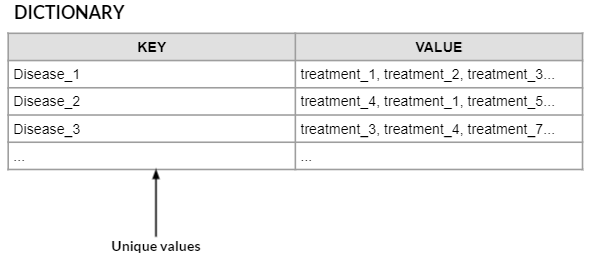

In [24]:
# extract indices of 'D' and 'T' from y_pred

d_indices = []
t_indices = []

for row in y_pred:
    d_indices.append([pos for pos, x in enumerate(row) if x == 'D'])
    t_indices.append([pos for pos, x in enumerate(row) if x == 'T'])

print(d_indices)
print(t_indices)

[[], [], [], [], [], [11, 12, 13, 14, 15, 16], [], [], [], [], [], [], [10, 16, 17, 18], [12], [], [3, 4], [], [], [], [], [6, 7, 8], [20, 21, 22, 23], [], [], [], [], [], [16], [], [37, 38, 43, 44, 50, 51], [], [], [], [6, 7], [11, 12], [], [10, 11, 12], [19, 20], [], [14, 15, 16, 17, 18], [], [], [], [], [], [], [13, 17, 18], [], [], [], [], [], [], [10, 11], [], [13], [], [], [], [], [], [9, 11], [], [], [], [], [], [], [], [], [], [27, 28, 29, 30, 31, 32], [], [18, 19], [], [9, 10, 11], [], [], [], [], [], [], [], [], [], [], [], [], [6, 7], [], [], [], [], [], [], [], [], [], [], [], [33, 34, 35], [], [], [22, 23, 24, 25, 30, 31], [], [12, 13, 14, 15], [], [], [], [4, 5], [], [34], [], [], [], [20, 21, 22, 23, 24, 25, 26, 27], [], [], [], [29, 30], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [0], [], [], [], [], [], [], [], [], [6, 7], [], [], [44], [], [11, 12], [], [5, 8, 9], [], [8, 9], [20, 21], [], [6, 7], [], [], [11, 12], [], 

In [25]:
# Now using d_indices to get names of diseases from test sentences
diseases_list = []

for i in range(len(d_indices)):
    d_list = []
    for j in d_indices[i]:
        d_list.append(test_sent[i].split()[j])
    diseases_list.append(d_list)
diseases_list

[[],
 [],
 [],
 [],
 [],
 ['macrosomic', 'infants', 'in', 'gestational', 'diabetes', 'cases'],
 [],
 [],
 [],
 [],
 [],
 [],
 ['microcephaly', 'nonimmune', 'hydrops', 'fetalis'],
 ['preeclampsia'],
 [],
 ['severe', 'preeclampsia'],
 [],
 [],
 [],
 [],
 ['asymmetric', 'double', 'hemiplegia'],
 ['reversible', 'nonimmune', 'hydrops', 'fetalis'],
 [],
 [],
 [],
 [],
 [],
 ['cancer'],
 [],
 ['breast', 'cancer', 'breast', 'cancer', 'ovarian', 'cancer'],
 [],
 [],
 [],
 ['prostate', 'cancer'],
 ['prostate', 'cancers'],
 [],
 ['hereditary', 'prostate', 'cancer'],
 ['prostate', 'cancer'],
 [],
 ['multiple', 'sclerosis', '(', 'MS', ')'],
 [],
 [],
 [],
 [],
 [],
 [],
 ['cancer', 'hereditary', 'retinoblastoma'],
 [],
 [],
 [],
 [],
 [],
 [],
 ['pericardial', 'effusions'],
 [],
 ['deafness'],
 [],
 [],
 [],
 [],
 [],
 ['epilepsy', 'ADHD'],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 ['unstable', 'angina', 'or', 'non-Q-wave', 'myocardial', 'infarction'],
 [],
 ['coronary-artery', 'disease'],
 [],

In [26]:
# Now using t_indices to get names of treatments from test sentences
treatments_list = []

for i in range(len(t_indices)):
    t_list = []
    for j in t_indices[i]:
        t_list.append(test_sent[i].split()[j])
    treatments_list.append(t_list)
treatments_list

[[],
 [],
 [],
 [],
 [],
 ['good', 'glycemic', 'control'],
 [],
 [],
 [],
 [],
 [],
 [],
 ['Trisomy'],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 ['radiotherapy'],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 ['hearing', 'aids'],
 [],
 [],
 [],
 ['methylphenidate'],
 [],
 ['Methylphenidate'],
 [],
 [],
 [],
 [],
 [],
 [],
 ['aspirin',
  ',',
  '3',
  'mg',
  'warfarin',
  'aspirin',
  ',',
  'or',
  '1',
  'mg',
  'warfarin',
  'aspirin'],
 ['warfarin', 'aspirin'],
 [],
 ['roxithromycin'],
 [],
 ['Antichlamydial', 'antibiotics'],
 ['surgery', 'radical', 'radiotherapy'],
 [],
 [],
 [],
 [],
 ['beta', 'human', 'chorionic', 'gondotropin'],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 ['electrical',
  'nerve',
  'stimulation',
  '(',
  'ENS',
  ')',
  'therapy',
  'electrical',
  'muscle',
  'stimulation',
  '(',
  'EMS',


In [28]:
# Create dataframe with diseases and treatments
df = pd.DataFrame({'Diseases': diseases_list, 'Treatments': treatments_list})
df.head(50)

,Diseases,Treatments
0,[],[]
1,[],[]
2,[],[]
3,[],[]
4,[],[]
5,"[macrosomic, infants, in, gestational, diabete...","[good, glycemic, control]"
6,[],[]
7,[],[]
8,[],[]
9,[],[]


In [30]:
# Remove blank rows from dataframe
df = df[df['Diseases'].apply(len) > 0]
df = df[df['Treatments'].apply(len) > 0]
df.head(100)

,Diseases,Treatments
5,"[macrosomic, infants, in, gestational, diabete...","[good, glycemic, control]"
12,"[microcephaly, nonimmune, hydrops, fetalis]",[Trisomy]
46,"[cancer, hereditary, retinoblastoma]",[radiotherapy]
55,[deafness],"[hearing, aids]"
61,"[epilepsy, ADHD]",[Methylphenidate]
...,...,...
901,"[syringomyelia, spinal, adhesive, arachnoiditis]","[Surgical, management]"
903,[bronchiectasis],"[antibiotics, and, surgery]"
907,"[biliary, dyskinesia]",[Cholecystectomy]
908,"[common, cold]","[pseudoephedrine, plus, acetaminophen]"


### Predict the treatment for the disease name: 'hereditary retinoblastoma'

In [33]:
# Search for words :: hereditary and retinoblastoma in Diseases column of df
search_strings = ['hereditary', 'retinoblastoma']
bool_index = df['Diseases'].apply(lambda x: any(item in x for item in search_strings))
result = df[bool_index]
print(result)

                                Diseases      Treatments
46  [cancer, hereditary, retinoblastoma]  [radiotherapy]


### ******************** END *****************************